<img src = "https://drive.google.com/uc?export=view&id=1XCFjEoG1OLaFbuntEH_PC7vtsII9wNfh" alt = "Encabezado MLDS" width = "100%">  </img>

# **Proyecto (Fase 3):** Reconocimiento vocal de ceatáceos 
## **Giovanny Alejandro Cuervo Londoño**

### Introducción
En este notebook se pretende continuar con el proyecto de **Reconocimiento vocal de cetaceos marinos** abordando la **fase No. 3**, donde se busca diseñar e implementar un modelo de **Deep learning** que permita lograr una mayor precisión en la identificación de mamíferos marinos utilizando registros de sus vocalizaciones. 

Con la implementación de este modelo, se espera mejorar en la clasificación de volcalizaciones de mamíferos marinos, con el fin de avanzar en la investigación y conservación de estas especies.



> Primero, instalamos y cargamos los paquetes necesarios para el tratamineto para el diseño e implementación del modelo de *deep learning*

In [23]:
# Instalamos algunos paquetes necasarios
!pip install noisereduce
!pip install ipython-autotime
!pip install tensorflow_io
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 21.0 MB/s eta 0:00:00
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 23.5 s (started: 2023-05-09 20:55:00 +00:00)


In [208]:
# Importamos los modulos
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
# Modulos extra
import librosa
import noisereduce as nr
import IPython.display as ipd
from numpy.random import randint
import scipy.io.wavfile as wav

time: 156 ms (started: 2023-05-10 00:10:17 +00:00)


In [114]:
print(f'Version de Tensorflow: {tf.__version__}')

Version de Tensorflow: 2.12.0
time: 6.96 ms (started: 2023-05-09 22:20:01 +00:00)


In [3]:
# Seleccionamos una semilla para los RNG (Random Number Generator)
tf.random.set_seed(123)
np.random.seed(123)

time: 893 µs (started: 2023-05-09 20:42:34 +00:00)


> Dado que los audios están guardados en Google drive es necesario conectar con Colab para caragar a los datos a esta sesión

In [5]:
# Conectamos con nuestro google drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive
time: 33.5 s (started: 2023-05-09 20:42:34 +00:00)


In [6]:
# Cargamos nuestro datos a colab descomprimidos
!unzip "/content/drive/MyDrive/Python/Deep learning/Proyecto/best-of-watkins-marine-mammal-sound-database.zip" -d ./content/

Streaming output truncated to the last 5000 lines.
  inflating: ./content/data/PantropicalSpottedDolphin/9400805V.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805W.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805X.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805Y.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805Z.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008060.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008061.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008062.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008063.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008064.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008065.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008066.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008067.wav  
  inflating: ./content/data/PantropicalSpottedDolphi

In [7]:
# Definimos un dataframe con los metadatos de los audios
df = pd.read_csv("/content/drive/MyDrive/Python/Deep learning/Proyecto/df_audios.csv").iloc[:, 1:]

time: 460 ms (started: 2023-05-09 20:48:41 +00:00)


In [8]:
# Data frame de los metadatos de los audios
df

,class,file_name,path,length_min,size_MB,SNR
0,Narwhal,7501400L.wav,./content/data/Narwhal/7501400L.wav,0.023633,0.221601,0.041813
1,Narwhal,68003007.wav,./content/data/Narwhal/68003007.wav,0.029922,0.140303,0.118808
2,Narwhal,7501400U.wav,./content/data/Narwhal/7501400U.wav,0.023633,0.221601,1.334958
3,Narwhal,7501400E.wav,./content/data/Narwhal/7501400E.wav,0.023633,0.221601,0.305832
4,Narwhal,6800200A.wav,./content/data/Narwhal/6800200A.wav,0.023633,0.221601,0.067411
...,...,...,...,...,...,...
15562,WestIndianManatee,64036001.wav,./content/data/WestIndianManatee/64036001.wav,0.017500,0.041059,0.456720
15563,WestIndianManatee,64013003.wav,./content/data/WestIndianManatee/64013003.wav,0.009130,0.020941,0.208792
15564,WestIndianManatee,64036006.wav,./content/data/WestIndianManatee/64036006.wav,0.014376,0.033735,3.720786
15565,WestIndianManatee,64009009.wav,./content/data/WestIndianManatee/64009009.wav,0.054392,0.377258,1.343921


time: 44.4 ms (started: 2023-05-09 20:48:42 +00:00)


### Funciones 
Para la implementación de dicho modelo, se utilizarán algunas funciones predefinidas. Estas funciones son útiles para el diseño, configuración e implementación modelo que se pretende abordar. 
El uso de estas funciones predefinidas facilitará la implementación del modelo de deep learning.

In [9]:
def get_list_path_from_subfolders(dir):
    """
    Crea una lista de rutas para cada uno de los archivos
    dentro de subfolders que estan en un directorio
    """
    # Lista con las rutas de cada archivo
    file_paths = []
    # Iterar sobre los subdirectorios y archivos en dir base
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            # Obtener la ruta completa del archivo
            file_path = os.path.join(subdir, file)
            # Agregar la ruta completa del archivo a la lista file_paths
            file_paths.append(file_path)
    return file_paths     

time: 922 µs (started: 2023-05-09 20:48:42 +00:00)


In [10]:
def get_df_labels_paths(list_paths):
    """
    Crea un df con dos columans
    clases o etiquetas y rutas o paths
    de los archivos de audio
    """
    # Diccionario con keys como columnas y values como datos para definir un df
    data = {'class': [os.path.basename(os.path.dirname(fp)) for fp in list_paths],
            'path': [fp for fp in list_paths]
            }
    # Dataframe a partir del diccionario datos
    return pd.DataFrame(data)


time: 1.03 ms (started: 2023-05-09 20:48:42 +00:00)


In [11]:
def get_rand_path(df):
    '''
    Seleccion aleatoria de un ruta con la misma probabilida
    entre las clases
    '''
    labels = df['class']
    # Obtiene las clases y su conteos
    classes, counts = np.unique(labels, return_counts=True)
    # Elige una clase de forma aleatoria
    rand_class = np.random.choice(classes)
    # Agrupa el df por la clase elegida
    df = df.loc[df['class'] == rand_class]
    # Elige una ruta al azar de la clase elegida 
    series_path = np.random.choice(df['path'])
    # Ruta y clase aleatoria
    return series_path, rand_class

time: 1.03 ms (started: 2023-05-09 20:48:42 +00:00)


In [12]:
def framed_signal(y, sr):
    """
    Retorna una senal segmentada en frames
    """
    # Define la longitud de cada frame en segundos
    f_l = 0.05
    # Define el tamano en pasos del frame y su ventana deslizante
    f_l_samples = int(f_l * sr)
    # Define el tamano de la ventana
    frame_length = f_l_samples
    # Tamano del paso
    hop_length =f_l_samples
    # En el caso de audios muy cortos
    if len(y) < frame_length: # Solver: ParameterError: Input is too short {} for frame_length={}
        frame_length = len(y)
        hop_length = len(y)
    # Halla unos frames que solo se usaran como indices
    frames = librosa.util.frame(np.arange(len(y)), 
                                frame_length = frame_length, 
                                hop_length =hop_length
                              )
    # Define una lista de tuplas
    # Cada tupla es el idx inicial y final de cada frame
    frame_idx = [(i * hop_length+1, 
                      i * hop_length + frame_length) for i in range(frames.shape[1])]
    # Hacemos cortes en la senal para defirnir los frame
    y_framed = [y[frame_idx[i][0]:frame_idx[i][1]] for i in range(len(frame_idx))]
    # Frames a nunpy
    y_framed = np.array(y_framed) 
    # Senal segmentada
    return y_framed

time: 938 µs (started: 2023-05-09 20:48:42 +00:00)


In [13]:
def filtered_signal(y, sr): 
    """
    Retorna una senal sin los frame mudos o los que
    no tienen el sonido caracteristico, por tanto son 
    frames sin informacion
    """
    # Segmenta la senal
    mean_y = y.mean()
    std_y = y.std()
    # Definir umbral
    threshold = mean_y + 1 * std_y
    # Senal segmentada
    y_framed = framed_signal(y, sr)
    # Solo conserva los segmentos con vocalizaciones
    y_filtered = []
    for fram in y_framed:
        if np.max(abs(fram)) >= threshold:
            y_filtered.extend(fram)
    # Senal filtrada
    return np.array(y_filtered)  

time: 700 µs (started: 2023-05-09 20:48:42 +00:00)


In [117]:
def load_wav_16k_mono(filename):
    """ 
    Carga un archivo WAV, lo convierte a un tensor con dtype float, 
    resample a 16 kHz monocanal. 
    """
    # Lee un audio de 8-bit
    fs, audio = wav.read(filename)
    # Convierte el audio a 16-bit formato int
    audio_16bit = (audio.astype('int16') - 128) * 256
    # Guarda el audio de 16-bit
    wav.write(filename, fs, audio_16bit)
    # Decodifica a binatio el archivo
    audio_16bit = tf.io.read_file(filename)
    # Convierte el audio a tensor
    wav_y, sample_rate = tf.audio.decode_wav(
          audio_16bit,
          desired_channels=1)
    # Elimina dimensiones de tamano 1
    wav_y = tf.squeeze(wav_y, axis=-1)
    # Cambia en dtype a int 64
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample de la senal
    wav_y = tfio.audio.resample(wav_y, rate_in=sample_rate, rate_out=16000)
    # Tensor senal y su sample rate
    return wav_y, sample_rate

time: 2.95 ms (started: 2023-05-09 23:26:44 +00:00)


In [15]:
def preprocess_audio(y, sr):
    """
    Funcion de preprocesamiento, utiliza las fuciones: 
    * nr.reduce_noise: para eliminar el ruido
    * filter_signal: para eliminar las parte sin vocalizacion
    """
    # Cuando el audio es muy corto
    if sr < 2**13: sr = 2**13 # Solver: freq_mask_smooth_hz needs to be at least {}Hz
    if len(y) <= 1048:
        n_fft = 512
    else:
        n_fft = 1024 # Solver: UserWarning: n_fft={} is too large for input signal of length={}
    # Reduccion de ruido
    y, sr = y.numpy(), sr.numpy()
    y = nr.reduce_noise(y = y, sr = sr, 
                        n_std_thresh_stationary=1.8, # 1.5, 
                        stationary=True, # True
                        n_fft=n_fft
                        )
    # Filtra las parte sin vocalizacion
    y = filtered_signal(y, sr)
    # Convertir el audio en un tensor TensorFlow
    audio_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
    # Tensor audio preprocesado y su sample rate
    return audio_tensor, sr

time: 1.46 ms (started: 2023-05-09 20:48:42 +00:00)


### Preprocesamiento

Para el preprocesamiento de los datos se utilizarán técnicas reducción de ruido y filtrado de sonido para el tratamiento de señal vocal. Este preprocesamiento es crucial para mejorar la calidad de los datos y garantizar un mejor rendimiento del modelo de deep learning.

In [193]:
# Definimos el directorio base
dir = './content/data/'
# Optenemos una lista de las rutas locales de cada audio
list_paths = get_list_path_from_subfolders(dir)
# Crea un df con dos columans clases y rutas
df_data =  get_df_labels_paths(list_paths)
# Elige una clase y una ruta aleatoria
signal_path, label = get_rand_path(df_data)
# Convierte el audio a uno de 16 bit monocanal
signal_wav_16k, sr = load_wav_16k_mono(signal_path)
# Preprocesamiento del audio
signal_prep, sr = preprocess_audio(signal_wav_16k, sr)
# Nombre del archivo elegido
f_name = os.path.basename(signal_path)

time: 182 ms (started: 2023-05-09 23:39:57 +00:00)


In [194]:
# Compara: Original vs preprocesado 
signal_original, sr = librosa.load(signal_path)
print(f"Original: {label} - {f_name}")
ipd.Audio(signal_original, rate=sr)

Original: Rough_ToothedDolphin - 8501301C.wav


time: 15.6 ms (started: 2023-05-09 23:39:58 +00:00)


In [195]:
# Compara: Original vs preprocesado 
print(f"Preproces: {label} - {f_name}")
ipd.Audio(signal_prep, rate=sr)

Preproces: Rough_ToothedDolphin - 8501301C.wav


time: 6.72 ms (started: 2023-05-09 23:40:03 +00:00)


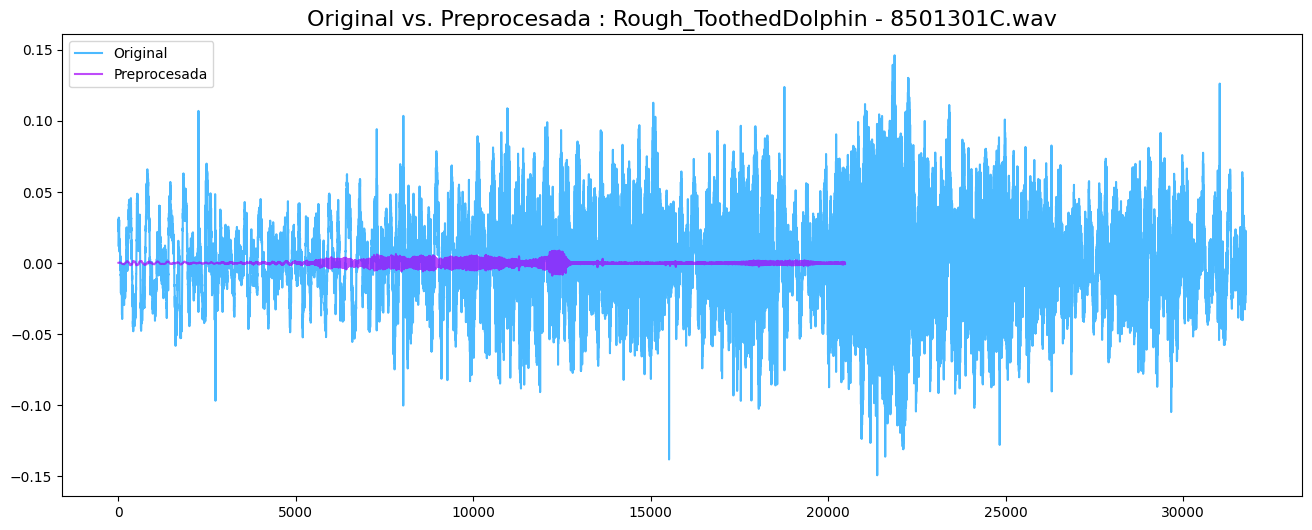

time: 3.02 s (started: 2023-05-09 23:45:36 +00:00)


In [205]:
# Compara: Original vs preprocesado  
plt.figure(figsize = (16, 6))
plt.plot(signal_original, color = '#009DFF', alpha=0.7, label='Original')
plt.plot(signal_prep, color = '#A300F9', alpha=0.7, label='Preprocesada')
plt.title(f"Original vs. Preprocesada : {label} - {f_name}", fontsize=16)
plt.legend();

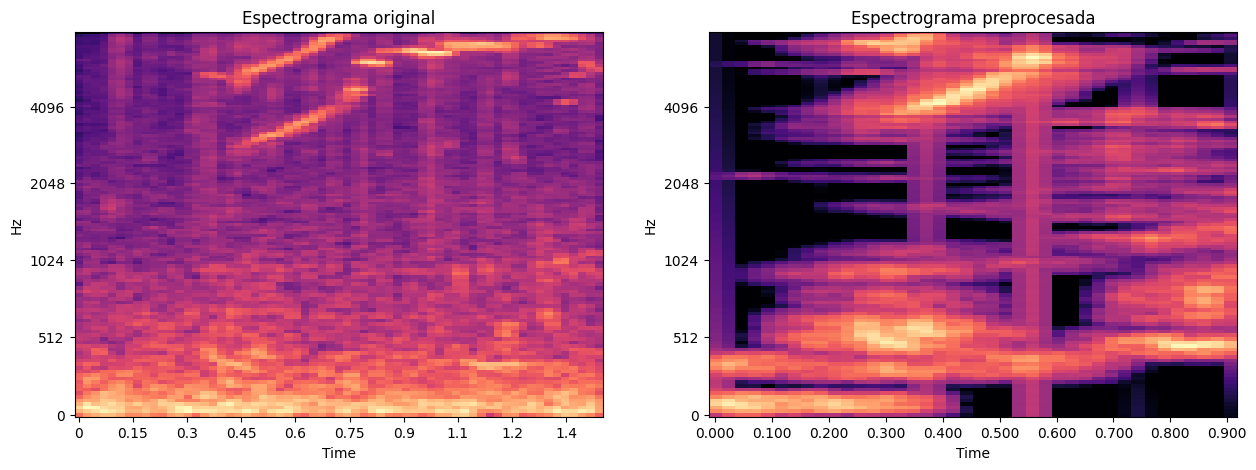

time: 993 ms (started: 2023-05-09 23:44:39 +00:00)


In [202]:
# Compara: Original vs preprocesado en espectrograma
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
spectrogram = librosa.feature.melspectrogram(y=signal_original, sr=sr)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time', ax=axs[0])
axs[0].set(title='Espectrograma original')
spectrogram = librosa.feature.melspectrogram(y=signal_prep.numpy(), sr=sr)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time', ax=axs[1])
axs[1].set(title='Espectrograma preprocesada');

# **Diseño e implementación experimental**
---

Este notebook es una plantilla que le puede servir como guía para el tercer entregable del proyecto aplicado.

## **1. Particion del conjunto de datos**
---

Si el dataset no tiene por defecto definida una partición en conjuntos de entrenamiento y prueba, hágala usted, en las proporciones que considere oportunas.

> Crea un Dataframe con clases balanceadas, del mismo tamaño del conjunto de datos, con señales elegidas al azar; dicho conjunto de datos balanceado se presenta como dataframe, cuyas columnas son las rutas y etiquetas de los audios junto con la representacion codificada en enteros y en one hot de las etiquetas.

In [17]:
# Definimos el directorio base
dir = './content/data/'
# Retorna una lista con todas las rutas locales de los audios
list_paths = get_list_path_from_subfolders(dir)
# Retorna un df con las etiquetas y las rutas
df_data =  get_df_labels_paths(list_paths)
# Crea un dataframe vacio para iteracion
df_for_dataset = pd.DataFrame(columns=['class', 'path'])
# Iteramos en cada una de las rutas
for _ in range(len(list_paths)):
    # Elige una ruta y respectiva etiqueta de forma aletoria
    signal_path, label = get_rand_path(df_data)
    # Crea un df de una fila con la ruta y etiqueta elegida
    df_2 = pd.DataFrame({'class': [label],
                         'path': [signal_path]
                         })
    # Concatena o agrega dicha ruta al df vacio
    df_for_dataset = pd.concat([df_for_dataset, df_2], 
                               ignore_index=True)
# Crea un dict para codificar a entero las etiquetas
idx_label_dict = {label: i for i, label in enumerate(set(df_for_dataset['class']))}
# Define columna vacia al df iterado
df_for_dataset['label_encoded'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df_for_dataset['label_encoded'] = df_for_dataset['class'].map(lambda clase: idx_label_dict[clase])
# Codifica a one hot las etiquetas
one_hot_labels = tf.keras.utils.to_categorical(df_for_dataset['label_encoded'])
# Define una columana con las etiquetas codificadas en one hot
df_for_dataset['one_hot'] = one_hot_labels.tolist()
# Dataframe con clases balanceadas
df_for_dataset

,class,path,label_encoded,one_hot
0,SpinnerDolphin,./content/data/SpinnerDolphin/8103800Y.wav,23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,LeopardSeal,./content/data/LeopardSeal/6608400T.wav,39,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,GraySeal,./content/data/GraySeal/63001002.wav,53,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Heaviside'sDolphin,./content/data/Heaviside'sDolphin/75015006.wav,32,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,TucuxiDolphin,./content/data/TucuxiDolphin/66014009.wav,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
15562,WestIndianManatee,./content/data/WestIndianManatee/64008006.wav,46,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15563,StellerSeaLion,./content/data/StellerSeaLion/63016002.wav,47,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15564,AtlanticSpottedDolphin,./content/data/AtlanticSpottedDolphin/6102600Q...,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15565,WeddellSeal,./content/data/WeddellSeal/64043005.wav,45,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


time: 4min 9s (started: 2023-05-09 20:48:42 +00:00)


> Se decidió tomar un subconjunto de datos ($500$) para el entrenamiento del modelo debido a la gran cantidad de muestras que se disponía. Realizar el entrenamiento del modelo con todo el conjunto de datos puede relentizar el proceso y hacerlo más costoso en términos de tiempo y recursos computacionales. 

> Además, al tomar un subconjunto de datos se puede evaluar la efectividad del modelo en un tiempo más corto, lo que permite iterar más rápidamente sobre su diseño y ajuste. Sin embargo, para garantizar que el subconjunto elegido sea representativo de la población total, se tomaron de forma aleatoria datos hasta completar un total igual al de conjunto de datos orginal, aunque esto puede llevar a tener datos repetidos es posible obtener un conjunto de datos balanceado.

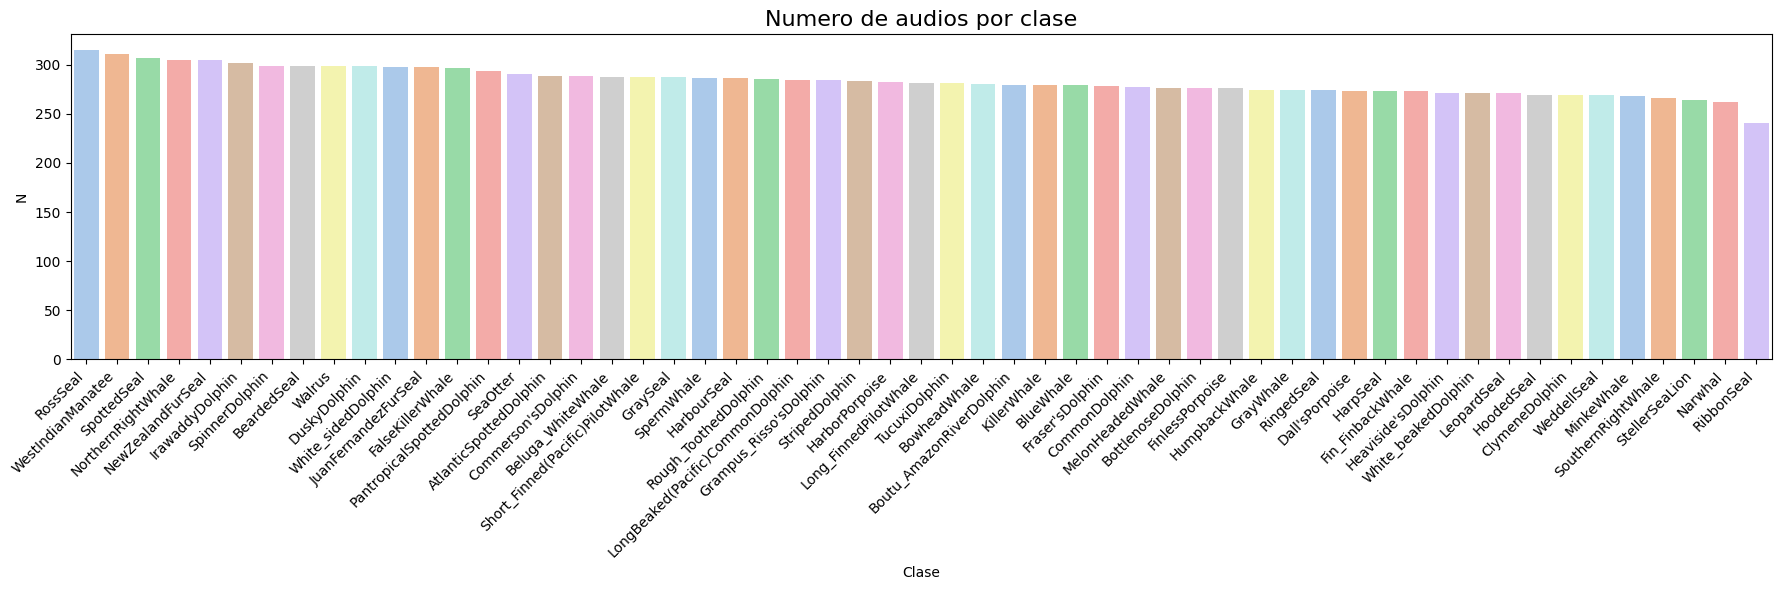

time: 2.25 s (started: 2023-05-10 00:11:27 +00:00)


In [210]:
# Nuevo data set con datos balanceados
fig = plt.figure(figsize=(18, 6))
sorted_class_ascend = df_for_dataset['class'].value_counts()
fig = sns.barplot(x=sorted_class_ascend.index, y=sorted_class_ascend.values, palette="pastel")
plt.xticks(rotation=45, ha="right")
plt.title(f"Numero de audios por clase", fontsize=16);
plt.ylabel('N')
plt.xlabel('Clase')
plt.tight_layout()

In [106]:
# Un subconjunto de datos
df_for_dataset_500 = df_for_dataset[:500]

time: 2.44 ms (started: 2023-05-09 22:12:43 +00:00)


> Con el nuevo conjunto de datos balanceado se puede definir los subconjuntos de prueba ($0.7 + 0.2$) y evaluación ($0.1$).

In [107]:
# Particion del conjunto de datos
from sklearn.model_selection import train_test_split
# Define conjuntos: train y test
X_train, X_test, y_train, y_test = train_test_split(df_for_dataset_500['path'], 
                                                    df_for_dataset_500['label_encoded'], 
                                                    test_size=0.1, 
                                                    random_state=42
                                                    )

time: 5.24 ms (started: 2023-05-09 22:12:44 +00:00)


> El conjunto de validación se definirá posteriormente a partir del conjutno de entrenamiento a la hora de definir el generador de datos.

## **2. Selección y diseño de modelos**
---

Seleccione el/los modelo/s a explorar para aplicar sobre el conjunto de datos. Recuerde, la selección del modelo está influenciada por diferentes factores. Si el problema es de análisis de imagen, muy seguramente hay que explorar diversas redes neuronales convolucionales. Si el problema está relacionado con NLP, muy seguramente hay que explorar modelos basados en Tranformers.

Además, debe definir cuál es su problema:

- **Regresión**: se busca estimar un valor continúo a partir de los datos.
- **Clasificación**: permite estimar un valor categórico a partir de los datos.
- **Agrupamiento**: permite encontrar grupos de datos similares.
- **Otros modelos**: recuerde que dispone de otros tipos de tareas supervisadas y no supervisadas.

En cualquier caso los profundos disponibles en _TensorFlow_ constituyen una base sobre la que usted debe definir un clasificador/regresor/_encoder_/_decoder_ final, compuesto de una o más capas densas, con opción de incluir _dropout_ o capas de normalización. 

Justifique la escogencia y diseño de los modelos a explorar:

> El modelo que se eligió fue el **YAMNet**, el cual, fue diseñado específicamente para la clasificación de audios cortos de sonidos ambientales, lo cual se ajusta muy bien a las necesidades del problema.

> Además, se utilizó **transfer learning** debido a que la base de datos <a href="https://cis.whoi.edu/science/B/whalesounds/index.cfm"> Watkins Marine Mammal Sound Database</a>, de vocalizaciones de mamíferos marinos, era relativamente pequeña en comparación con otros problemas de clasificación de audio para los que ha sido utilizada dicha red. La metodología utilizada se expone detalladamente en el artículo <a href="https://www.tensorflow.org/tutorials/audio/transfer_learning_audio#split_the_data"> Transfer learning with YAMNet for environmental sound classification</a>.

>  La arquitectura **YAMNet** utiliza una capa **convolucional** profunda con filtros de Gabor, que han demostrado ser eficaces en la detección de patrones complejos en los espectrogramas de audio, lo que la hace adecuada para el reconocimiento de vocalizaciones de mamíferos marinos.

## **3. Implementación de los modelos**
---

Implemente los modelos descritos anteriormente usando herramientas de _TensorFlow_. Recuerde que puede aplicar técnicas de aumentación de datos, si es necesario.

---**INGRESE SU RESPUESTA**---

In [34]:
# Cargamos el modelo preentrenado Yamnet
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)
print(type(yamnet_model))

<class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>
time: 9.98 s (started: 2023-05-09 21:01:26 +00:00)


> Es necesario realizar un preprocesamiento especial para la entrada de dicho modelo preentrenado.

In [16]:
# Definimos una serie de funciones para preprocesamiento para Yamnet
def load_wav_for_map(filename, label):
    """
    Wraper para de la funcion:
    * load_wav_16k_mono
    para el tf.data.Dataset.from_tensor_slices
    """
    # Convierte un tensor a numpy
    filename = filename.numpy().decode()
    y, sr = load_wav_16k_mono(filename)
    return y, sr, label

def proproces_for_map(y, sr, label):
    """
    Wraper para de la funciones:
    * nr.reduce_noise
    * filtered_signal
    para el tf.data.Dataset.from_tensor_slices
    """
    # Reduccion de ruido
    y, sr = y.numpy(), sr.numpy()
    if sr < 2**13: sr = 2**13 # Solver: freq_mask_smooth_hz needs to be at least {}Hz
    y = nr.reduce_noise(y = y, sr = sr, 
                        n_std_thresh_stationary=1.8, # 1.5, 
                        stationary=True, # True
                        )
    y = filtered_signal(y, sr)
    # Convertir el audio en un tensor TensorFlow
    audio_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
    return audio_tensor, sr, label

# Extrae embedding de los datos para la entrada al modelo
def extract_embedding(wav_data, label):
    ''' 
    Extraccion de embeddings de datos tipo wav
    para la YAMNet 
    '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(label, num_embeddings))

time: 2.79 ms (started: 2023-05-09 20:48:42 +00:00)


> Con algunos de los datos no fue posible convertirlos al formato de entrada del modelo **Yamnet**, posiblmente debido a su codificado. Por lo que, fue necesario descartar dichos datos

In [108]:
# Salta o descarta los datos que presenten error en load_wav_for_map
def load_wav_for_map_skipErr(fname, label):
    try:
        # Si no hay error aplica la funcion
        return load_wav_for_map(fname, label)
    except:
        # Si hay error retorna None
        return (None, sr, label)
# Salta o descarta los datos que presenten error en proproces_for_map
def proproces_for_map_skipErr(y, sr, label):
    try:
        # Si no hay error aplica la funcion
        return proproces_for_map(y, sr, label)
    except:
        # Si hay error retorna None
        return (None, sr, label)

time: 1.05 ms (started: 2023-05-09 22:12:47 +00:00)


> Ahora definimos un **Pipeline** para el preprocesamiento y tratamiento especial con embeddings para **Yamnet**.

In [109]:
# Define el generador de datos
main_ds = tf.data.Dataset.from_tensor_slices((X_train, 
                                              y_train))
# Aplica la funcion load_wav_for_map_skipErr a los datos
main_ds = main_ds.map(lambda fname, label : (tf.py_function(load_wav_for_map_skipErr,
                                                                [fname, label], 
                                                                [tf.float32, tf.int64, tf.int64])))
# Aplica la funcion proproces_for_map_skipErr a los datos
main_ds = main_ds.map(lambda y, sr, label : (tf.py_function(proproces_for_map_skipErr,
                                                            [y, sr, label], 
                                                            [tf.float32, tf.int64, tf.int64])))
# Remueve los None del conjunto de datos 
# Correspondiente a los datos donde no fue posbile aplicar las funciones anteriores
main_ds = main_ds.cache().filter(lambda y, sr, label: y is not None or sr is not None)
# En este putno el sr no es necesario por lo que lo descarta
main_ds = main_ds.map(lambda embedding, sr, label: (embedding, label))
# Extrae los embedings necesario para la entrada a Yamnet
main_ds = main_ds.map(extract_embedding).unbatch()
# Aleatoriza el orden de los datos de entrenamiento 
main_ds = main_ds.cache().shuffle(buffer_size=len(df_for_dataset['path']))

time: 245 ms (started: 2023-05-09 22:12:49 +00:00)


In [27]:
main_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

time: 13.8 ms (started: 2023-05-09 20:56:08 +00:00)


> En este punto se definien los conjuntos de entrenamiento ($0.7$) y validacion ($0.2$).

In [110]:
|# Numero total de datos del subconjunto
num_examples = len(df_for_dataset_500['path'])
# Define los tamanos de los conjuntos de entreneminto y validacion
train_size = int(0.7 * num_examples)
val_size = int(0.2 * num_examples)
print(f'Train: {train_size}, validation: {val_size}')
# Divide los datos en conjuntos de: entrenamiento y validation
train_data = main_ds.cache().take(train_size).repeat()
val_data = main_ds.cache().skip(train_size).take(val_size).repeat()
# Define tamano del batch
batch_size = 64
# Define los batch para los conjuntos train y validation
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_data.element_spec

Train: 350, validation: 100


(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

time: 25.4 ms (started: 2023-05-09 22:12:55 +00:00)


In [29]:
train_data.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

time: 8.43 ms (started: 2023-05-09 20:56:34 +00:00)


In [111]:
# Define la parte superior del modelo para Calentamiento (Warming Up)
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(df['class'])))
    ], name='my_model')
# Resumen de las capas superiores de salida
my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 55)                28215     
                                                                 
Total params: 553,015
Trainable params: 553,015
Non-trainable params: 0
_________________________________________________________________
time: 70.7 ms (started: 2023-05-09 22:13:07 +00:00)


In [112]:
# Compilacion: define funcion de perdida y optimizador
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])
# Define Callbacks para monitores de la perdida en validacion
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='val_checkpoint.h5', 
                                                      monitor="val_loss", 
                                                      verbose=True, 
                                                      save_best_only=True,
                                                      save_weights_only=True, 
                                                      mode="min")
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=50,
                                            mode="min",
                                            restore_best_weights=True)
callbacks = [checkpoint, stopping]

time: 21.7 ms (started: 2023-05-09 22:13:17 +00:00)


In [113]:
# Calcula el numero de validation steps
validation_steps = int(0.7 * num_examples) // batch_size
# Calcula el numero de steps_per_epoch
steps = int(0.7 * num_examples)// batch_size 
# Entrena las capas superiores
history = my_model.fit(train_data,
                       epochs= 500,
                       validation_data = val_data,
                       steps_per_epoch = steps,
                       validation_steps= validation_steps,
                       callbacks = callbacks)


Epoch 1/500


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:1781: RuntimeWarning: divide by zero encountered in log10
  log_spec: np.ndarray = 10.0 * np.log10(np.maximum(amin, magnitude))
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=288
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=322
  warnings.warn(


4/5 [=======================>......] - ETA: 0s - loss: 4.1200 - accuracy: 0.0508  
Epoch 1: val_loss improved from inf to 3.84375, saving model to val_checkpoint.h5
5/5 [==============================] - 94s 138ms/step - loss: 4.0741 - accuracy: 0.0531 - val_loss: 3.8438 - val_accuracy: 0.0812
Epoch 2/500
4/5 [=======================>......] - ETA: 0s - loss: 3.8440 - accuracy: 0.0898
Epoch 2: val_loss improved from 3.84375 to 3.70645, saving model to val_checkpoint.h5
5/5 [==============================] - 0s 65ms/step - loss: 3.8179 - accuracy: 0.1031 - val_loss: 3.7064 - val_accuracy: 0.1219
Epoch 3/500
3/5 [=================>............] - ETA: 0s - loss: 3.7455 - accuracy: 0.0781
Epoch 3: val_loss improved from 3.70645 to 3.69782, saving model to val_checkpoint.h5
5/5 [==============================] - 0s 48ms/step - loss: 3.6760 - accuracy: 0.1375 - val_loss: 3.6978 - val_accuracy: 0.1875
Epoch 4/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7602 - accuracy: 0.152

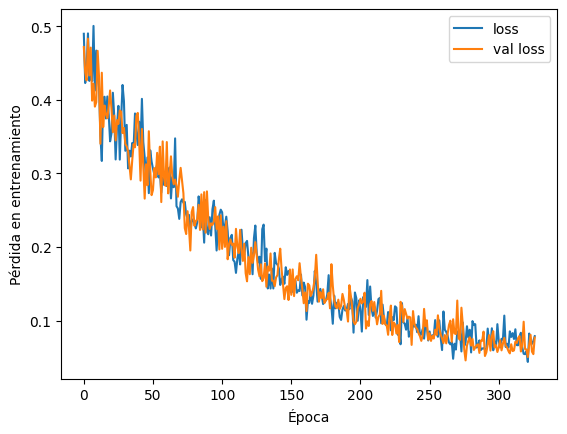

time: 980 ms (started: 2023-05-09 22:10:39 +00:00)


In [105]:
# Entrenamiento de las capas superiores del modelo
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")
plt.legend()

In [58]:
loss, accuracy = my_model.evaluate(test_data)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1/1 [==============================] - 0s 211ms/step - loss: 0.0794 - accuracy: 0.9800
Loss:  0.07940156012773514
Accuracy:  0.9800000190734863
time: 273 ms (started: 2023-05-09 21:22:57 +00:00)


> Evaluamos el modelo preentrenado **Yamnet** junto con las capas superiores ya entrenadas.

In [89]:
# Wraper de la funcion load_wav_16k_mono_test
@tf.function
def load_wav_16k_mono_test(filename):
    """ 
    Wraper de load_wav_16k_mono para test
    """
    wav_y, _ = load_wav_16k_mono(filename)
    return wav_y

time: 4.3 ms (started: 2023-05-09 21:40:27 +00:00)


In [92]:
# Realizamos la evaluacion del modelo con datos que nunca ha visto
# Lista de valores unicos de clases
my_classes = list(set(df_for_dataset['class']))
# Lista de predicciones del modelo
predictions = []
for x in X_test:
    # Parte profunda del modelo preentrenada
    scores, embeddings, spectrogram = yamnet_model(load_wav_16k_mono_test(x))
    # Parte superior del modelo que se entreno previamente
    result = my_model(embeddings).numpy()
    # Vector resultante de logits para cada clase
    logits_vect = result.mean(axis=0)
    # Clase predicha
    inferred_class = my_classes[logits_vect.argmax()]
    # Adiciona al vector de predicciones
    predictions.append(inferred_class)

time: 21.5 s (started: 2023-05-09 21:43:24 +00:00)


In [102]:
from sklearn.metrics import *
# Decoficamos las predicciones
flip_idx_label_dict = {value: key for key, value in idx_label_dict.items()}
y_test_clases = [flip_idx_label_dict[idx] for idx in y_test]
# Reporte de clasificacion
print(classification_report(y_test_clases, predictions))

                           precision    recall  f1-score   support

   AtlanticSpottedDolphin       0.00      0.00      0.00         1
              BeardedSeal       0.03      1.00      0.05         1
        Beluga_WhiteWhale       0.33      1.00      0.50         1
                BlueWhale       0.00      0.00      0.00         2
        BottlenoseDolphin       0.00      0.00      0.00         1
 Boutu_AmazonRiverDolphin       0.00      0.00      0.00         1
           Dall'sPorpoise       0.00      0.00      0.00         2
             DuskyDolphin       0.00      0.00      0.00         1
         FalseKillerWhale       0.00      0.00      0.00         1
         Fin_FinbackWhale       0.00      0.00      0.00         1
          FinlessPorpoise       0.00      0.00      0.00         3
          Fraser'sDolphin       0.00      0.00      0.00         1
   Grampus_Risso'sDolphin       0.00      0.00      0.00         1
                 GraySeal       0.00      0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/) 
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](mailto:mrodrigueztr@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*